# Setting Up

In [68]:
import nltk.corpus

from config.constants import *
from config.utils import *

df = DATA_INPUTS['main_dataset']

if len(df) != 0:
    logger.info(f'Dataframe imported successfully with a length of {len(df)} 🎉')

2023-08-20 19:19:26.519 | INFO     | __main__:<module>:9 - Dataframe imported successfully with a length of 10000 🎉


In [69]:
print(f'There are {len(df.columns)} columns: {list(df.columns)}.')

There are 9 columns: ['link', 'headline', 'category', 'short_description', 'authors', 'date', 'tokens', 'refined_text', 'vector'].


In [70]:
categories = df.category.unique()
print(f'There are {len(categories)} columns:\n')

half = len(categories) // 2
left_col = categories[:half]
right_col = categories[half:]

for left, right in zip(left_col, right_col):
    print(f'{left: <25}{right}')

There are 12 columns:

ENTERTAINMENT            BUSINESS
COMEDY                   SCIENCE
QUEER VOICES             WORLD NEWS
TECH                     EDUCATION
WELLNESS                 MONEY
BLACK VOICES             ARTS & CULTURE


In [71]:
df.category.value_counts()

category
WELLNESS          2535
ENTERTAINMENT     2463
QUEER VOICES       959
BUSINESS           853
COMEDY             798
BLACK VOICES       686
WORLD NEWS         496
TECH               311
SCIENCE            310
MONEY              253
ARTS & CULTURE     190
EDUCATION          146
Name: count, dtype: int64

# Tokenizer

In [72]:
def tokenizer(text: str, stopwords: set = STOPWORDS, punctuations: set = PUNCTUATIONS) -> tuple[list, str]:
    emojis = demoji.findall(text)
    
    new_text = ''
    for character in text:
        if character in emojis.keys():
            new_text += str.join('_', str.split(emojis[character])) + ' '
        else:
            new_text += character
    
    lemmatizer = WordNetLemmatizer()
    lemmas = [ lemmatizer.lemmatize(word) for word in word_tokenize(new_text) ]
    tokens = [ str.lower(token) for token in lemmas if token not in stopwords and token not in punctuations ]
    
    refined_text = str.join(' ', tokens)
    
    if len(tokens) == 0:
        return ['NULL'], 'NULL'
    else:
        return tokens, refined_text

In [73]:
df['tokens'], df['refined_text'] = df.headline.apply(lambda x: tokenizer(x, STOPWORDS, PUNCTUATIONS)[0]), df.headline.apply(lambda y: tokenizer(y, STOPWORDS, PUNCTUATIONS)[-1])

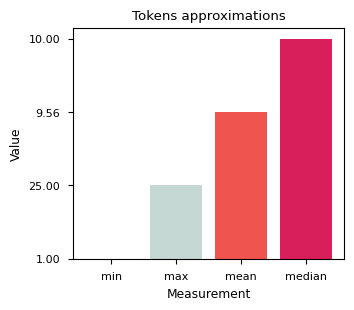

In [74]:
def token_approximation(text: str) -> int:
  return len(str.split(text))

ta = dict({
  'min': f'{np.min([token_approximation(text) for text in df.refined_text.tolist()]):.2f}',
  'max': f'{np.max([token_approximation(text) for text in df.refined_text.tolist()]):.2f}',
  'mean': f'{np.mean([token_approximation(text) for text in df.refined_text.tolist()]):.2f}',
  'median': f'{np.median([token_approximation(text) for text in df.refined_text.tolist()]):.2f}'
})

token_approximations = pd.DataFrame(list(ta.items()), columns=['measurement', 'value'])

plt.figure(figsize=(3.5, 3))
plt.style.use('seaborn-v0_8-paper')

plt.bar(token_approximations.measurement, token_approximations.value, color=['#fdf0d5', '#c6d8d3', '#f0544f', '#d81e5b'])
plt.title('Tokens approximations')
plt.xlabel('Measurement')
plt.ylabel('Value')
plt.show()

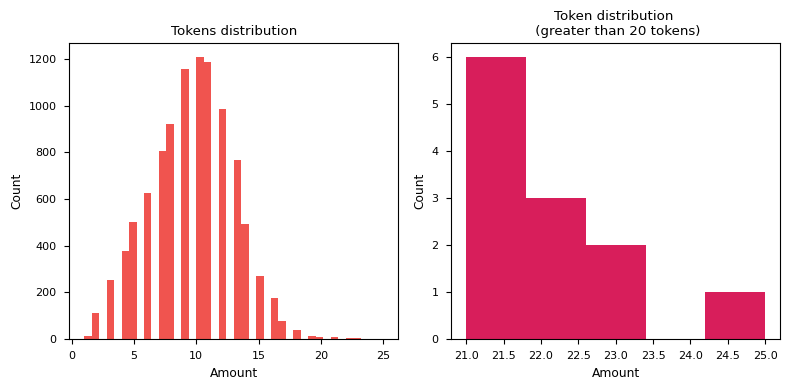

In [75]:
aux = df.copy(deep=True)
aux['tl'] = aux.tokens.apply(lambda x: len(x))
aux = aux.tl.tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.hist(aux, bins=40, color='#f0544f')
ax1.set_title('Tokens distribution')
ax1.set_xlabel('Amount')
ax1.set_ylabel('Count')

aux2 = df.copy(deep=True)
aux2['tl'] = aux2.tokens.apply(lambda x: len(x))
aux2 = aux2.query('tl > 20')
aux2 = aux2.tl.tolist()

ax2.hist(aux2, bins=5, color='#d81e5b')
ax2.set_title('Token distribution \n (greater than 20 tokens)')
ax2.set_xlabel('Amount')
ax2.set_ylabel('Count')

plt.tight_layout()
plt.show()


# Vectorizer

In [76]:
vocab = list()
for tokens in df.tokens:
    vocab.extend(tokens)

vocab = set(vocab)
vocab = dict(zip(vocab, range(2, len(vocab) + 2)))
vocab['UNK'] = 1
vocab['PAD'] = 0
vocab = dict(sorted(vocab.items(), key=lambda item: item[1]))

In [77]:
def get_ids(text: str, max_length: int) -> np.ndarray[int]:
  text = str.lower(text)
  vector = [vocab[word] if word in vocab.keys() else vocab['UNK'] for word in text.split()]
  vector = vector[:max_length] + [vocab['PAD']] * (max_length - len(vector))
  return np.array(vector)

def get_attention_mask(ids: np.ndarray[int]) -> np.ndarray[int]:
  return np.array([1 if id > 0 else 0 for id in ids])

def ids_decoder(ids: np.ndarray[int], vocab: dict[str, int]) -> str:
  reconstruction = list(vocab.keys())[list(vocab.values()).index(ids[0])]
  for i in ids[1:]:
      word = list(vocab.keys())[list(vocab.values()).index(i)]
      word = ' ' + word if word != 'PAD' else ''
      reconstruction += word
      
  return reconstruction

max_length = 32
sample_text = df.sample(1, random_state=26).refined_text.values[0]
input_ids = get_ids(sample_text, max_length)
attention_mask = get_attention_mask(input_ids)

input_ids, attention_mask

(array([10804,  4849, 12825,  2127,  6170,  9823,   616, 14837,  5054,
        11890,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [78]:
df['vector'] = df.refined_text.apply(lambda x: get_ids(text=x, max_length=32))

In [79]:
df.sample(10)

,link,headline,category,short_description,authors,date,tokens,refined_text,vector
61200,https://www.huffingtonpost.com/entry/comic-con...,This Young Girl's Shocking Question Totally Wo...,ENTERTAINMENT,Out of the mouth of babes.,Bill Bradley,2016-07-24,"[this, young, girl, 's, shocking, question, to...",this young girl 's shocking question totally w...,"[3021, 11570, 11027, 5052, 7579, 7787, 1763, 1..."
37342,https://www.huffingtonpost.com/entry/30-years-...,"30 Years Ago, Bill Murray Called A Full Cubs G...",COMEDY,"""This is the closest I've been to actually hav...",Andy McDonald,2017-04-21,"[30, years, ago, bill, murray, called, a, full...",30 years ago bill murray called a full cubs ga...,"[14363, 13349, 354, 13449, 15873, 2364, 5931, ..."
135143,https://www.huffingtonpost.com/entry/success-a...,How to Figure Out What You Want Out of Life,WELLNESS,Most of us have a fuzzy idea of what we want n...,"Amita Patel, Contributor\nOwner and Founder of...",2014-04-01,"[how, figure, out, what, you, want, out, life]",how figure out what you want out life,"[14446, 12983, 13015, 1271, 318, 10382, 13015,..."
172498,https://www.huffingtonpost.com/entry/mindful-e...,Breaking the Diet/Binge Cycle,WELLNESS,Having spent decades bouncing back and forth b...,"Andrea Wachter, Contributor\nPsychotherapist a...",2013-03-01,"[breaking, diet/binge, cycle]",breaking diet/binge cycle,"[14447, 1594, 13998, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
179000,https://www.huffingtonpost.com/entry/federal-e...,Employee Issued 5-Page Formal Reprimand For Fa...,BUSINESS,"The 38-year-old, who worked out of a Baltimore...",,2012-12-22,"[employee, issued, 5-page, formal, reprimand, ...",employee issued 5-page formal reprimand for fa...,"[3524, 7114, 7942, 4800, 10058, 1027, 4986, 28..."
116525,https://www.huffingtonpost.com/entry/virgin-ga...,Richard Branson: Virgin Galactic Will 'Not Pus...,BUSINESS,,Alexander C. Kaufman,2014-11-01,"[richard, branson, virgin, galactic, will, 'no...",richard branson virgin galactic will 'not push...,"[5224, 379, 2502, 4164, 1527, 12371, 1130, 505..."
147929,https://www.huffingtonpost.com/entry/values_us...,The Danger of Values,WELLNESS,The political danger of values has to do with ...,"Michael Jinkins, Contributor\nMichael Jinkins ...",2013-11-15,"[the, danger, values]",the danger values,"[14326, 14224, 5017, 0, 0, 0, 0, 0, 0, 0, 0, 0..."
47104,https://www.huffingtonpost.com/entry/the-most-...,The Most Important American Movie Of 2016,ENTERTAINMENT,2016 has not been a very good year for mainstr...,"Jon Eig, ContributorFilm teacher and screenwriter",2017-01-01,"[the, most, important, american, movie, of, 2016]",the most important american movie of 2016,"[14326, 14824, 8360, 901, 8579, 5335, 2906, 0,..."
108576,https://www.huffingtonpost.com/entry/what-top-...,What Top Financial Consultants Think Every Ent...,BUSINESS,"There's a ""secret"" just for entrepreneurs that...","Andre Bourque, ContributorEditor Emeritus, Tec...",2015-02-01,"[what, top, financial, consultants, think, eve...",what top financial consultants think every ent...,"[1271, 13027, 5917, 1492, 15170, 3815, 13916, ..."
96317,https://www.huffingtonpost.com/entry/the-art-o...,The Art of Being Alive Series: Color Blind Mil...,BLACK VOICES,In the past 12 months my brother has been hara...,"Adedayo Fashanu, ContributorJournalist & Autho...",2015-06-22,"[the, art, being, alive, series, color, blind,...",the art being alive series color blind millenn...,"[14326, 8622, 8305, 14780, 4593, 12705, 7197, ..."


# Label Encoding

In [104]:
le = LabelEncoder()
le.fit(df.category.tolist())
le.classes_

array(['ARTS & CULTURE', 'BLACK VOICES', 'BUSINESS', 'COMEDY',
       'EDUCATION', 'ENTERTAINMENT', 'MONEY', 'QUEER VOICES', 'SCIENCE',
       'TECH', 'WELLNESS', 'WORLD NEWS'], dtype='<U14')

In [117]:
joblib.dump(value=le, filename='../assets/artifacts/label_encoder.pkl', compress=True)

['../assets/artifacts/label_encoder.pkl']

In [119]:
df['le_category'] = le.transform(df.category)

In [120]:
df.sample(5)

,link,headline,category,short_description,authors,date,tokens,refined_text,vector,le_category
86915,https://www.huffingtonpost.com/entry/broad-cit...,"The 'Broad City' Ladies Have A Spa Day, But It...",ENTERTAINMENT,This hilarious video makes us even more excite...,Joe Satran,2015-10-06,"[the, 'broad, city, ladies, have, a, spa, day,...",the 'broad city ladies have a spa day but it d...,"[14326, 7112, 8142, 12077, 9785, 5931, 3972, 1...",5
8423,https://www.huffpost.com/entry/elon-musk-thai-...,"Elon Musk Lashes Out At Thai Cave Rescuer, Bas...",WORLD NEWS,British diver Vern Unsworth had mocked the Tes...,Hayley Miller,2018-07-15,"[elon, musk, lashes, out, at, thai, cave, resc...",elon musk lashes out at thai cave rescuer base...,"[5680, 2802, 13495, 13015, 2895, 13091, 1165, ...",11
16725,https://www.huffingtonpost.com/entry/james-cor...,Trump And Steve Bannon Look Back With Rose-Col...,COMEDY,They almost had it all.,Lee Moran,2018-01-09,"[trump, and, steve, bannon, look, back, with, ...",trump and steve bannon look back with rose-col...,"[3112, 10490, 12780, 11589, 3243, 9282, 10116,...",3
202221,https://www.huffingtonpost.com/entry/stress-aw...,10 Health Benefits Of Relaxation,WELLNESS,You may have heard that a little bit of stress...,Sarah Klein,2012-04-16,"[10, health, benefits, of, relaxation]",10 health benefits of relaxation,"[3030, 11143, 13641, 5335, 9990, 0, 0, 0, 0, 0...",10
202030,https://www.huffingtonpost.com/entry/gps-soul_...,Accessing the Wisdom of the Soul,WELLNESS,I find this idea of using technology to help u...,"Dr. Judith Rich, Contributor\nContributor",2012-04-18,"[accessing, wisdom, soul]",accessing wisdom soul,"[5388, 5617, 13454, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",10
